<a href="https://colab.research.google.com/github/fboldt/isdog/blob/main/kaggle_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from google.colab import files
# files.upload()

# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# !kaggle competitions download -c dog-breed-identification

# !unzip dog-breed-identification.zip

In [2]:
import os, pathlib
import shutil
import pandas as pd

train_ori = pathlib.Path('train')

newdir = 'kaggle'
if not os.path.exists(newdir):
    os.makedirs(newdir)
kaggle = pathlib.Path(newdir)

def move_images(image, label, dest_dir, source_dir):
    _ = os.path.join(dest_dir, label)
    if not os.path.exists(_):
        os.makedirs(_)
    source = os.path.join(source_dir, f'{image}.jpg')
    destination = os.path.join(dest_dir, label, f'{image}.jpg')
    if os.path.exists(source) and not os.path.exists(destination):
        shutil.copyfile(source, destination)

labels = pd.read_csv('./labels.csv').to_numpy()
for image, label in labels:
    move_images(image, label, kaggle, train_ori)

In [3]:
image_size = 180
batch_size = 32
seed = 42
validation_split=0.25

In [4]:
from tensorflow.keras.utils import image_dataset_from_directory
train_dataset = image_dataset_from_directory(newdir,
                                             image_size=(image_size, image_size),
                                             validation_split=validation_split,
                                             subset="training",
                                             seed=seed,
                                             batch_size=batch_size)
validation_dataset = image_dataset_from_directory(newdir,
                                             image_size=(image_size, image_size),
                                             validation_split=validation_split,
                                             subset="validation",
                                             seed=seed,
                                             batch_size=batch_size)

Found 10222 files belonging to 120 classes.
Using 7667 files for training.
Found 10222 files belonging to 120 classes.
Using 2555 files for validation.


In [5]:
num_breed = 120

In [8]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
  ]
)

conv_base = keras.applications.vgg16.VGG16(weights="imagenet", include_top=False)
conv_base.trainable = False

''' # without augmentation
inputs = conv_base.input
x = conv_base.output
''' # with augmentation
inputs = keras.Input(shape=(image_size, image_size, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
#'''

x = layers.BatchNormalization()(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_breed, activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.compile(loss="sparse_categorical_crossentropy",
  optimizer="rmsprop",
  metrics=["accuracy"])

callbacks = [
  keras.callbacks.ModelCheckpoint(filepath="vgg16.x", save_best_only=True, monitor="val_loss"),
  keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
]

history = model.fit(train_dataset, epochs=30, validation_data=validation_dataset, callbacks=callbacks)

Epoch 1/30
240/240 [==============================] - 53s 164ms/step - loss: 3.2193 - accuracy: 0.2306 - val_loss: 1.9257 - val_accuracy: 0.4736
Epoch 2/30
240/240 [==============================] - 36s 147ms/step - loss: 1.9877 - accuracy: 0.4540 - val_loss: 1.8269 - val_accuracy: 0.5170
Epoch 3/30
240/240 [==============================] - 38s 156ms/step - loss: 1.6817 - accuracy: 0.5281 - val_loss: 1.6811 - val_accuracy: 0.5746
Epoch 4/30
240/240 [==============================] - 32s 132ms/step - loss: 1.4668 - accuracy: 0.5768 - val_loss: 1.7440 - val_accuracy: 0.5699
Epoch 5/30
240/240 [==============================] - 32s 132ms/step - loss: 1.2960 - accuracy: 0.6244 - val_loss: 1.8756 - val_accuracy: 0.5804
Epoch 6/30
240/240 [==============================] - 32s 132ms/step - loss: 1.1824 - accuracy: 0.6596 - val_loss: 1.9321 - val_accuracy: 0.5800
Epoch 7/30
240/240 [==============================] - 32s 131ms/step - loss: 1.0202 - accuracy: 0.6983 - val_loss: 2.0104 - val_ac

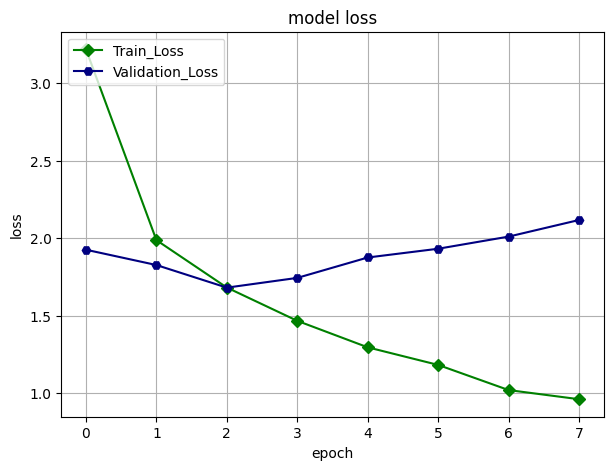

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.plot(history.history['loss'],color="green",marker="D")
plt.plot(history.history['val_loss'],color="navy",marker="H")
plt.grid(True)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train_Loss', 'Validation_Loss'], loc='upper left')
plt.show()

In [10]:
#test_model = keras.models.load_model("vgg16.x")